<a href="https://colab.research.google.com/github/demotu/gait_score/blob/main/notebooks/data_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Gait Score Neuropathy (gait_score): Data validation and integration

> This notebook performs data validation and integration for analysis.
>
> All individual files are required to run this notebook; **it cannot be run in the cloud**.

## Python setup

In [1]:
# import libraries
import sys, os
from pathlib import Path  # file and directory paths in Python
import glob  # Unix style pathname pattern expansion
from datetime import datetime
import numpy as np  # large, multi-dimensional numeric arrays and matrices
import pandas as pd  # labelled tables with numeric and string data
import matplotlib  # data visualization
import matplotlib.pyplot as plt  # data visualization
import seaborn as sns  # data visualization
import xarray as xr  # labelled multi-dimensional arrays
from tqdm.notebook import tqdm  # progress bar
from IPython.display import display, Math, Latex  # IPython formatting
import scipy as sp  # collection of mathematical algorithms and convenience functions built on NumPy
sys.path.insert(1, r'./../functions')
import read_c3d_xr
# if os.getenv("COLAB_RELEASE_TAG"):
#     !pip install -q ipywidgets
# import ipywidgets
# try:
#     %matplotlib widget
# except:
#     !pip install -q ipympl
#     %matplotlib widget
# if os.getenv("COLAB_RELEASE_TAG"):
#     from google.colab import output
#     output.enable_custom_widget_manager()

print(f'Python {sys.version} on {sys.platform}', f' numpy {np.__version__}',
      f' scipy {sp.__version__}', f' pandas {pd.__version__}', f' read_c3d_xr {read_c3d_xr.__version__}',
      datetime.now().strftime("%d/%m/%Y %H:%M:%S"), sep='\n')

Python 3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 16:05:46) [GCC 13.3.0] on linux
 numpy 2.1.3
 scipy 1.14.1
 pandas 2.2.3
 read_c3d_xr 0.0.2
23/11/2024 23:38:15


In [2]:
# Environment configuration

sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 1})
sns.set_style('whitegrid')
colors = sns.color_palette()
display(colors)
style = [{'selector': 'th', 'props': [('text-align', 'left')]},
         {'selector': 'caption', 'props': [('font-weight', 'bold'), ('color', 'blue'), ('font-size', '120%')]}]
xr.set_options(keep_attrs=True)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

if (path := Path('/home/marcos/adrive/Python/projects/labimph/gait_score')).exists() is False:
    path = Path('/users/marcos/adrive/Python/projects/labimph/gait_score')
print(f'Path: {path}')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

Path: /home/marcos/adrive/Python/projects/labimph/gait_score


## Helping functions

In [13]:
#@title ### Helping functions {display-mode: "form"}
def get_all_features(fname, groups, show=True):
    """
    """
    fname0 = fname.name[:-len(fname.suffix)]
    names = fname0.split('_')
    _, subject, assessment, trial = names
    fname = fname.as_posix()
    if subject[1:] in groups['1']:
        group = '1'
    elif subject[1:] in groups['2']:
        group = '2'
    else:
        group = '0'

    prm = read_c3d_xr.get_parameters(fname)
    # basic validation
    if not prm['events']['1'][0] - prm['events']['0'][0] > 0:
        print('File {} does not have enough events.'.format(fname0))
        return {}

    grf = read_c3d_xr.read_c3d(fname, var='GRF', prm=prm)
    events = read_c3d_xr.find_ev_GRFcycle(grf)
    grf = read_c3d_xr.trimmer(grf, evs=events, trim=1)
    grf = read_c3d_xr.normala(grf, method='BM', mass=prm['mass'])
    #grf = read_c3d.normalt(grf, percent=True)
    fgrf = grf_walk_feats(grf, fname0, show=show)

    side = grf.Time.attrs['side']
    features = {'Filename' : prm['filename'],
                'Subject' : subject,
                'Group' : group,
                'Assessment' : assessment,
                'Trial' : trial,
                'Mass' : prm['mass'] if 'mass' in prm else np.nan,
                'Height' : prm['height'] if 'height' in prm else np.nan,
                'LegLength' : prm['LL'][side] if 'LL' in prm else np.nan,
                'FootLength' : prm['FL'][side] if 'FL' in prm else np.nan,
                'Cadence' : prm['Cadence'] if 'Cadence' in prm else np.nan,
                'Walking Speed' : prm['Walking Speed'] if 'Walking Speed' in prm else np.nan,
                'Stride Time' : prm['Stride Time'] if 'Stride Time' in prm else np.nan,
                'Foot Off' : prm['Foot Off'] if 'Foot Off' in prm else 100,
                'Stride Length' : prm['Stride Length'] if 'Stride Length' in prm else np.nan,
                'Duration' : np.round(events['1'][0]-events['0'][0], 3),
                'Stance Time' : np.nan,
                'Side' : 'L' if events['0'][1][0] == 'L' else 'R',
                'Cycle' : 'stride' if events['1'][1][1:] == 'FS' else 'step',
                'Events': [events],
               }
    features['Stance Time'] = np.round(features['Duration']*features['Foot Off']/100, 3)

    return features



def get_feature(y, feature='am', ini=0, end=0, freq=1, endpoint=True,
                atleast2=True):
    """Returns feature in `y`[`ini`:`end`+1] and index (instant) when feasible.

    Possible features:
    'am': amplitude (value) at `ini`
    'pk': peak (maximum) at `ini`:`end`
    'vl': valley (minimum) at `ini`:`end`
    'me': mean at `ini`:`end`
    'md': median at `ini`:`end`
    'sd': standard devation at `ini`:`end`
    'rs': root mean square at `ini`:`end`
    'rn': range at `ini`:`end`
    'rt': rate (derivative) at `ini`:`end`
    'it': total integral (area) at `ini`:`end`
    'ip': positive integral (positive area) at `ini`:`end`
    'in': negative integral (negative area) at `ini`:`end`

    """
    import numpy as np

    axis = 0
    if np.isnan(ini) or np.isnan(end):
        return np.nan, np.nan
    ini, end = int(np.round(ini*freq)), int(np.round(end*freq))
    if end == 0:
        end = len(y)
    elif endpoint:
        end += 1
    if ini > end or ini >= len(y):
        ini = min([end, len(y)-1])
    if not np.all(np.isnan(y[ini:end])):
        isatleast2 = (not atleast2) or (len(y[ini:end]) > 1)
        if isinstance(feature, list):
            feats = [get_feature(y, f, ini, end, freq, endpoint, axis) for f in feature]
            value, idx = [f[0] for f in feats], [f[1] for f in feats]
        elif feature == 'am':
            idx = ini
            value, idx = y[idx], idx if freq == 1 else idx/freq
        elif feature in ['pk', 'vl'] and isatleast2:
            fun = np.nanargmax if feature == 'pk' else np.nanargmin
            idx = fun(y[ini:end], axis=axis) + ini
            if y.ndim > 1:
                value = np.take_along_axis(y, np.atleast_2d(idx), axis=axis)
                idx = idx if freq == 1 else idx/freq
            else:
                value, idx = y[idx], idx if freq == 1 else idx/freq
        elif feature == 'me' and isatleast2:
            value, idx = np.nanmean(y[ini:end], axis=axis), np.nan
        elif feature == 'md' and isatleast2:
            value, idx = np.nanmedian(y[ini:end], axis=axis), np.nan
        elif feature == 'sd' and isatleast2:
            value, idx = np.nanstd(y[ini:end], axis=axis, ddof=-1), np.nan
        elif feature == 'rs' and isatleast2:
            value, idx = np.sqrt(np.nanmean(y[ini:end]**2, axis=axis)), np.nan
        elif feature == 'rn' and isatleast2:
            value, idx = (np.nanmax(y[ini:end], axis=axis) -
                          np.nanmin(y[ini:end], axis=axis), np.nan)
        elif feature == 'rt' and isatleast2:
            end = end if end < len(y) else len(y) - 1
            value, idx = (y[end]-y[ini])/((end-ini)/freq), np.nan
        elif feature == 'it' and isatleast2:
            value, idx = np.trapezoid(y[ini:end], axis=axis)/freq, np.nan
        elif feature in ['ip', 'in'] and isatleast2:
            fun = np.greater if feature == 'ip' else np.less
            if y.ndim > 1:
                value = np.empty(y.shape[1])
                for c in range(y.shape[1]):
                    value[c] = np.trapezoid(y[fun(y[ini:end, c], 0), c])
                idx = np.nan
            else:
                value, idx = np.trapezoid(y[fun(y[ini:end], 0)])/freq, np.nan
        else:
            value, idx = np.nan, np.nan

        if isinstance(value, np.ndarray) and not isinstance(idx, np.ndarray):
            idx = np.array([idx]*len(value))
        value = np.squeeze(value)
    else:
        value, idx = np.nan, np.nan

    return value, idx



def grf_walk_feats(data, fname=None, show=True):
    """Calculate features of GRF during walking.
    """
    ft = {}
    side = data.Time.attrs['side']
    color = {'L': 'r', 'R': 'b'}
    color = {'L': 'k', 'R': 'k'}
    cs = color[side]
    c2 = 'g'
    freq = data.Time.attrs['rate']
    FO = data.Time.attrs['events'][side+'FO'][0]
    units = data.attrs['units']
    # Forces
    var = 'Force1'
    if var in data.Var.values:
        y = data.sel(Var=var).values
    else:
        #print('Missing variable in data: {}'.format(var))
        y = np.array([[np.nan, np.nan, np.nan]])
    Fml, Fap, Fv = y[:, 0], y[:, 1], y[:, 2]
    i0 = 0.1*FO  # to skip first portion of GRF
    half = FO/2

    ft['GFvtPKt1'] = get_feature(Fv, 'pk', ini=i0, end=half, freq=freq)
    ft['GFvtPKt2'] = get_feature(Fv, 'pk', ini=half, end=0, freq=freq)
    _, GFvePKt0t = get_feature(Fv - ((Fv[int(i0*freq)]-Fv[0])/i0)*np.arange(0, len(Fv))/freq,
                               'pk', ini=0, end=i0, freq=freq)
    #ft['GFvePKt0'] = (Fv[int(np.round(GFvePKt0t*freq))], GFvePKt0t)
    ft['GFvtPKt0'] = get_feature(Fv, 'am', ini=GFvePKt0t, end=0, freq=freq)
    ft['GFvtVLt1'] = get_feature(Fv, 'vl', ini=ft['GFvtPKt1'][1], end=ft['GFvtPKt2'][1], freq=freq)
    ft['GFapPKt1'] = get_feature(Fap, 'vl', ini=i0, end=half, freq=freq)
    ft['GFapPKt2'] = get_feature(Fap, 'pk', ini=half, end=0, freq=freq)
    ft['GFvtIPal'] = get_feature(Fv, 'ip', ini=0, end=0, freq=freq)

    ft['GFvtRTt0'] = get_feature(Fv, 'rt', ini=0, end=ft['GFvtPKt0'][1], freq=freq)
    ft['GFvtRTt1'] = get_feature(Fv, 'rt', ini=0, end=ft['GFvtPKt1'][1], freq=freq)
    ft['GFapINal'] = get_feature(Fap, 'in', ini=0, end=0, freq=freq)
    ft['GFapIPal'] = get_feature(Fap, 'ip', ini=0, end=0, freq=freq)
    ft['GFapRTt1'] = get_feature(Fap, 'rt', ini=0, end=ft['GFapPKt1'][1], freq=freq)

    if show:
        time = data.Time.values
        v = [var]
        v = [x for x in v if x in data.Var.values]
        g = data.sel(Var=v).plot.line(x='Time', row='Var', col='Axis', sharey=False,
                                      size=3.23, aspect=1.16, color=cs)
        read_c3d_xr.plot_lines(g.axs, data.Time.attrs['events'], show=False)

        j = {'G':0}
        a = {'ml':0, 'ap':1, 'vt':2}
        axs = g.axs
        for f in ft:
            if not np.isnan(ft[f][1]):
                axs[j[f[0]], a[f[2:4]]].plot(ft[f][1], ft[f][0], c2+'o')
                dy = .05 if np.sign(ft[f][0]) > 0 and f[4:6]!='VL' else -.1
                dy = dy*np.diff(axs[j[f[0]], a[f[2:4]]].get_ylim())
                axs[j[f[0]], a[f[2:4]]].text(ft[f][1], ft[f][0]+dy, f[4:], color=c2,
                                             horizontalalignment='center',
                                             bbox=dict(facecolor='white', edgecolor='none',
                                                       pad=0, alpha=.6))

        axs[0, 1].fill_between(time[Fap<0], 0, Fap[Fap<0], hatch=r'\\',
                               fc='none', ec='k', linewidth=0.0)  # color=[1, 0, 0, .2]
        axs[0, 1].fill_between(time[Fap>0], 0, Fap[Fap>0], hatch='//',
                               fc='none', ec='k', linewidth=0.0)  # color=[0, 1, 0, .2]
        if not np.isnan(ft['GFapPKt1'][1]):
            axs[0, 1].plot([0, ft['GFapPKt1'][1]], [0, ft['GFapPKt1'][0]], c=c2, ls=':', lw=2)
            axs[0, 1].text(ft['GFapPKt1'][1], ft['GFapPKt1'][0]*0.4, 'INal',
                           horizontalalignment='center', color=c2,
                           bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=1))
        if not np.isnan(ft['GFapPKt2'][1]):
            axs[0, 1].text(ft['GFapPKt2'][1], ft['GFapPKt2'][0]*0.3, 'IPal',
                            horizontalalignment='center', color=c2,
                            bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=1))
        axs[0, 2].fill_between(time[Fv>0], 0, Fv[Fv>0], hatch='//',
                               fc='none', ec='k', linewidth=0.0)
        if not np.isnan(ft['GFvtPKt0'][1]):
            axs[0, 2].plot([0, ft['GFvtPKt0'][1]], [0, ft['GFvtPKt0'][0]], c=c2, ls=':', lw=2)
        if not np.isnan(ft['GFvtPKt1'][1]):
            axs[0, 2].plot([0, ft['GFvtPKt1'][1]], [0, ft['GFvtPKt1'][0]], c=c2, ls=':', lw=2)
            axs[0, 2].axhline(y=0, c='k', lw=0.5)
        if not np.isnan(ft['GFvtVLt1'][1]):
            axs[0, 2].text(ft['GFvtVLt1'][1], ft['GFvtVLt1'][0]*0.3, 'IPal',
                            horizontalalignment='center', color=c2,
                            bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=1))
        if fname:
            g.fig.suptitle('Ground Reaction Forces - Trial: {}'.format(fname),
                           fontsize=12, y=.95)
        plt.tight_layout()
        plt.savefig(path2_figures / (fname + '_grf.png'))
        #plt.show()

    return ft



def val_data(path2, groups):
    """Validate data files given path and file naming convention.
    """
    # c3d files in the directory:
    filenames = list(path2.glob('*.c3d'))
    filenames.sort()
    #filenames = filenames[:10]
    print(f'Number of c3d files in {path2.name}: {len(filenames)}')

    df = pd.DataFrame()
    show = False
    with tqdm(total=len(filenames), desc='Loading files...') as pbar:
        f = 0
        for fname in filenames:
            pbar.set_description(f'Trial {fname.name[:-4]: <13}')
            pbar.update()
            features = get_all_features(fname, groups=groups, show=show)
            if features['Cycle'] == 'stride' and features['Group'] != '0':
                del features['Cycle']
                df = pd.concat((df, pd.DataFrame(data=features, index=[f])), axis=0)
                f += 1
            if show:
                plt.close('all')
    print('Done.')

    #df.index.name = 'Index'
    df.dropna(axis=1, how='all', inplace=True)
    df['Trial'] = pd.to_numeric(df['Trial'])
    df.sort_values(by=['Group', 'Assessment', 'Subject', 'Trial'],
                   ignore_index=True, inplace=True)

    df['G'] = df['Group'].factorize()[0]  # categorize by order of appearance
    df['A'] = df['Assessment'].astype('category').cat.codes
    df['S'] = df['Subject'].factorize()[0]
    df['T'] = df[['Group', 'Assessment', 'Subject', 'Trial'
                 ]].groupby(['Group', 'Assessment',
                             'Subject']).transform(lambda x: pd.factorize(x.index)[0])
    df.drop(columns='Events', inplace=True)
    df.to_csv(path2 / f'metadata_{path2.name}.csv', na_rep='nan', float_format='%.6f')

    return df


def describre_data(df):
    display(metadata)
    display(df[['Group', 'Assessment', 'Subject', 'Trial', 'Side', 'G', 'A', 'S', 'T']])
    print('Number of subjects per group and assessment:')
    display(df.drop_duplicates(subset=['Subject', 'Assessment'], inplace=False
                              )[['Group', 'Assessment', 'Subject']].groupby(['Group', 'Assessment']).count().T)
    print('Descriptive statistics for the number of trials by subject per group and assessment:')
    display(df[['Group', 'Assessment', 'Subject', 'Trial']
              ].groupby(['Group', 'Assessment', 'Subject']).count().groupby(['Group', 'Assessment']).describe())



def processa(fname, prm, var='Angle', methodt='interp', step=2):
    """
    """
    data = read_c3d_xr.read_c3d(fname, var=var, prm=prm)
    events = read_c3d_xr.find_ev_GRFcycle(data)
    side = data.Time.attrs['side']
    data = read_c3d_xr.trimmer(data, evs=events, trim=1)
    data = read_c3d_xr.normalt(data, method=methodt, step=step)
    if var == 'Angle':
        var2 = [side + joint for joint in ['Pelvis', 'Hip', 'Knee', 'Ankle', 'FootProgress']] # or FTA
        data = data.sel(Var=var2)
    elif var == 'Moment':
        var2 = [side + joint for joint in ['Hip', 'Knee', 'Ankle']]
        data = data.sel(Axis=['ML'], Var=var2)
        data = read_c3d_xr.normala(data, method='', value=1, units='Nm/(BM)')

    return data



def create_da(m, step=2, variable='Angle', path2=''):
    """X dimensions [time, joint, axis, trial, subject, assessment, group]
    """
    # array with dimensions [time, var, axis, trial, subject, assessment, group]
    joint = {'Angle': 3, 'Moment': 4}
    X = np.full((int(100/step)+1, joint[variable], 3, m['T'].max()+1, m['S'].max()+1, m['A'].max()+1, m['G'].max()+1), np.nan)
    print(f'DataArray dimensions for variable {variable} [time, joint, axis, trial, subject, assessment, group]: {X.shape}')
    with tqdm(total=m.shape[0], desc='Loading files...') as pbar:
        for (filename, g, a, s, t) in m[['Filename', 'G', 'A', 'S', 'T']].itertuples(index=False, name=None):
            fullname = path2 / f'{filename}.c3d'
            pbar.set_description(f'Trial {fullname.name[:-4]: <13}')
            pbar.update()
            prm = read_c3d_xr.get_parameters(fullname.as_posix())
            data = processa(fullname.as_posix(), prm, var=variable, methodt='interp', step=step)
            # store only the angles to calculate the GPS
            X[:, 0, :, t, s, a, g] = data.sel(Var=data.Time.attrs['side']+'Pelvis').values
            X[:, 1, :, t, s, a, g] = data.sel(Var=data.Time.attrs['side']+'Hip').values
            X[:, 2, 0, t, s, a, g] = data.sel(Var=data.Time.attrs['side']+'Knee', Axis='ML').values
            X[:, 2, 1, t, s, a, g] = data.sel(Var=data.Time.attrs['side']+'Ankle', Axis='ML').values
            X[:, 2, 2, t, s, a, g] = data.sel(Var=data.Time.attrs['side']+'FootProgress', Axis='VT').values
            if np.mean(X[:, 2, 2, t, s, a, g]) < 0:
                X[:, 2, 2, t, s, a, g] = -X[:, 2, 2, t, s, a, g]

    coords = {}
    coords['Time'] = data.Time.values
    coords['Joint'] = [x[1:] for x in data.Var.values[:3]]
    coords['Axis'] = data.Axis.values
    coords['Trial'] = range(X.shape[3])
    coords['Subject'] = m['Subject'].unique()
    coords['Assessment'] = m['Assessment'].unique()
    coords['Group'] = m['Group'].unique()
    dims = ('Time', 'Joint', 'Axis', 'Trial', 'Subject', 'Assessment', 'Group')
    da = xr.DataArray(data=X, dims=dims, coords=coords, name=data.name)
    da.attrs['units'] = data.attrs['units']
    da.Time.attrs['units'] = data.Time.attrs['units']

    return da



def create_da2(m, step=2, variable='Angle', path2=''):
    """
    """
    # array with dimensions [time, var, axis, trial, subject] for angle
    joint = {'Angle': 3, 'Moment': 4}
    axis = {'Angle': 3, 'Moment': 1}
    X = np.full((int(100/step)+1, joint[variable], axis[variable], m['T'].max()+1, m['S'].max()+1), np.nan)
    print(f'DataArray dimensions for variable {variable} [time, joint, axis, trial, subject]: {X.shape}')
    with tqdm(total=m.shape[0], desc='Loading files...') as pbar:
        for (filename, s, t, p) in m[['Filename', 'S', 'T', 'Project']].itertuples(index=False, name=None):
            fullname = path2 / p / f'{filename}.c3d'
            pbar.set_description(f'Trial {fullname.name[:-4]: <13}')
            pbar.update()
            prm = read_c3d_xr.get_parameters(fullname.as_posix())
            data = processa(fullname.as_posix(), prm, var=variable, methodt='interp', step=step)
            if variable == 'Angle':
                # store only the angles to calculate the GPS kinematic
                X[:, 0, :, t, s] = data.sel(Var=data.Time.attrs['side']+'Pelvis').values
                X[:, 1, :, t, s] = data.sel(Var=data.Time.attrs['side']+'Hip').values
                X[:, 2, 0, t, s] = data.sel(Var=data.Time.attrs['side']+'Knee', Axis='ML').values
                X[:, 2, 1, t, s] = data.sel(Var=data.Time.attrs['side']+'Ankle', Axis='ML').values
                X[:, 2, 2, t, s] = data.sel(Var=data.Time.attrs['side']+'FootProgress', Axis='VT').values
                if np.mean(X[:, 2, 2, t, s]) < 0:
                    X[:, 2, 2, t, s] = -X[:, 2, 2, t, s]
            elif variable == 'Moment':
                # store only the moments to calculate the GPS kinetic
                X[:, 0, 0, t, s] = data.sel(Var=data.Time.attrs['side']+'Hip', Axis='ML').values
                X[:, 1, 0, t, s] = data.sel(Var=data.Time.attrs['side']+'Knee', Axis='ML').values
                X[:, 2, 0, t, s] = data.sel(Var=data.Time.attrs['side']+'Ankle', Axis='ML').values
                X[:, 3, 0, t, s] = np.nansum(X[:, :3, 0, t, s], axis=1)  # support moment
                X[:, 3, 0, t, s] = X[:, 0, 0, t, s] + X[:, 1, 0, t, s] + X[:, 2, 0, t, s]

    coords = {}
    coords['Time'] = data.Time.values
    coords['Axis'] = data.Axis.values
    dims = ('Time', 'Joint', 'Axis', 'Trial', 'Subject')
    if variable == 'Angle':
        coords['Joint'] = [x[1:] for x in data.Var.values[:3]]
    elif variable == 'Moment':
        coords['Joint'] = [x[1:] for x in data.Var.values[:3]] + ['Support']
    coords['Trial'] = range(X.shape[3])
    coords['Subject'] = m['Subject'].unique()
    dims = ('Time', 'Joint', 'Axis', 'Trial', 'Subject')
    da = xr.DataArray(data=X, dims=dims, coords=coords, name=data.name)
    da.attrs['units'] = data.attrs['units']
    da.Time.attrs['units'] = data.Time.attrs['units']
    return da



def plot_ensemble(path2, metadata, da):
    groups = metadata['Group'].unique()
    assessments = metadata['Assessment'].unique()
    assessments = assessments[0]
    variable = 'Angle'
    joints = list(da.Joint.values)
    axes = list(da.Axis.values)
    for group in groups:
        for assessment in assessments:
            metadata2 = metadata.query('Group  == @group & Assessment == @assessment')
            NT = metadata2.shape[0]
            NS = metadata2['Subject'].unique().size
            print(f'{path2.name}, G{group}{assessment}: Joint angles Ensemble ({NS} subjects and {NT} trials)')
            dam = (da.sel(Group=group, Assessment=assessment).dropna(dim='Subject', how='all')
                     .reduce(np.nanquantile, q=.5, dim='Trial')) #da.reduce(np.nanmean, dim='Trial')

            dam.plot(x='Time', hue='Subject', row='Joint', col='Axis');
            plt.suptitle(f'{path2.name}, G{group}{assessment}: joint angles ensemble ({NS} subjects and {NT} trials)')
            sns.move_legend(plt.gcf(), loc='center left', bbox_to_anchor=(1, 0.5))
            plt.tight_layout()
            plt.show()



def plot_ensemble2(path2, metadata, da, variable='Angle'):
    joints = list(da.Joint.values)
    axes = list(da.Axis.values)
    NT = metadata.shape[0]
    NS = metadata['Subject'].unique().size
    print(f'{path2.name}: Joint {variable} Ensemble ({NS} subjects and {NT} trials)')
    dam = (da.dropna(dim='Subject', how='all')
             .reduce(np.nanquantile, q=.5, dim='Trial')) #da.reduce(np.nanmean, dim='Trial')

    dam.plot(x='Time', hue='Subject', row='Joint', col='Axis');
    plt.suptitle(f'{path2.name}: Joint {variable} ensemble ({NS} subjects and {NT} trials)')
    sns.move_legend(plt.gcf(), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8, ncol=3)
    plt.tight_layout()
    plt.show()


def plot_select(path2, metadata, da, variable='Angle'):
    def func(t, A, tau):
        """Saturating Exponential"""
        return A*(1 - np.exp(-t/tau))

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_ylim([-0.1, 10])
    ax.grid(True)
    plt.xlabel('Tempo', fontsize=16)
    plt.ylabel('Amplitude', fontsize=16)
    t = np.linspace(0, 300, 101)
    V = func(t, 5, 50)

    @ipywidgets.interact(A=(0, 10, .5), tau=(1, 100, 1))
    def update(A=5, tau=50):
        """Remove old lines from plot and plot new one"""
        [l.remove() for l in ax.lines]
        ax.plot(t, func(t, A, tau), color='r', lw=3)
        plot_ensemble2(path2, metadata, da.sel(Subject=subject), variable=variable)

## Data validation

### Project RonaldJane

In [14]:
path2 = path / 'data/RonaldoJane'
fname = path2 / f'metadata_{path2.name}.csv'
groups = {'1': ['23','24','16','18','22','26','27','29','34','35',
                '38','40','41','45','46','48','49','52','54','55',
                '57','61','62','63','64','66','69','72','73','74',
                '75'],
          '2': ['30','28','25','04','07','02','20','17','19','21',
                '31','33','36','37','39','42','43','44','47','50',
                '51','53','56','58','59','60','65','67','68','70',
                '71']}
assessments = ['T00', 'T12', 'T24']
# file naming convention
# <S_Sxx_Tyy_z.c3d>
# xx: subject ID number
# yy: assessment number
# z : trial number

if fname.exists():
    metadata = pd.read_csv(fname, sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
else:
    metadata = val_data(path2, groups)

describre_data(metadata)

Number of c3d files in RonaldoJane: 1237


Loading files...:   0%|          | 0/1237 [00:00<?, ?it/s]

Done.


,Filename,Subject,Group,Assessment,Trial,Mass,Height,LegLength,FootLength,Cadence,...,Stride Time,Foot Off,Stride Length,Duration,Stance Time,Side,G,A,S,T
0,S_S16_T00_9,S16,1,T00,9,76.5,1.550,0.746,0.194,114.504,...,1.048,71.947,1.077,1.048,0.754,L,0,0,0,0
1,S_S22_T00_2,S22,1,T00,2,73.8,1.595,0.755,0.185,109.290,...,1.098,65.756,1.102,1.098,0.722,R,0,0,1,0
2,S_S22_T00_5,S22,1,T00,5,73.8,1.595,0.755,0.185,112.045,...,1.071,64.986,1.097,1.071,0.696,R,0,0,1,1
3,S_S22_T00_6,S22,1,T00,6,73.8,1.595,0.755,0.192,109.689,...,1.094,64.442,1.045,1.094,0.705,L,0,0,1,2
4,S_S22_T00_10,S22,1,T00,10,73.8,1.595,0.755,0.185,108.011,...,1.111,63.906,1.136,1.111,0.710,R,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,S_S67_T24_11,S67,2,T24,11,75.9,1.660,0.760,0.199,103.627,...,1.158,63.126,1.132,1.158,0.731,R,1,2,58,5
821,S_S67_T24_12,S67,2,T24,12,75.9,1.660,0.760,0.199,103.986,...,1.154,62.305,1.138,1.154,0.719,R,1,2,58,6
822,S_S67_T24_13,S67,2,T24,13,75.9,1.660,0.760,0.199,103.004,...,1.165,62.747,1.132,1.165,0.731,R,1,2,58,7
823,S_S67_T24_14,S67,2,T24,14,75.9,1.660,0.760,0.199,101.868,...,1.178,62.054,1.140,1.178,0.731,R,1,2,58,8


,Group,Assessment,Subject,Trial,Side,G,A,S,T
0,1,T00,S16,9,L,0,0,0,0
1,1,T00,S22,2,R,0,0,1,0
2,1,T00,S22,5,R,0,0,1,1
3,1,T00,S22,6,L,0,0,1,2
4,1,T00,S22,10,R,0,0,1,3
...,...,...,...,...,...,...,...,...,...
820,2,T24,S67,11,R,1,2,58,5
821,2,T24,S67,12,R,1,2,58,6
822,2,T24,S67,13,R,1,2,58,7
823,2,T24,S67,14,R,1,2,58,8


Number of subjects per group and assessment:


Group        1           2        
Assessment T00 T12 T24 T00 T12 T24
Subject     28  19  14  27  20  18

Descriptive statistics for the number of trials by subject per group and assessment:


Trial                                                
                 count      mean       std  min   25%  50%   75%   max
Group Assessment                                                      
1     T00         28.0  6.714286  2.636737  1.0  5.00  6.5  9.00  10.0
      T12         19.0  6.263158  2.600045  1.0  5.00  6.0  8.50  10.0
      T24         14.0  6.142857  2.851643  1.0  4.25  6.5  8.00  10.0
2     T00         27.0  6.629630  2.705381  2.0  5.00  6.0  9.00  10.0
      T12         20.0  7.000000  2.733804  2.0  5.75  7.5  9.25  10.0
      T24         18.0  6.277778  2.845131  1.0  5.00  7.0  8.00  10.0

### Project Erica

In [15]:
path2 = path / 'data/Erica'
fname = path2 / f'metadata_{path2.name}.csv'
groups = {'1': ['02','04','06','07','11','12','14','15','16','23',
                '24','27','31','33','45','47','48','50','52','53',
                '56','57','58','59','60'],
          '2': ['01','03','05','08','09','10','13','17','18','19',
                '20','21','25','26','29','30','32','34','35','38',
                '43','44','46','51','55']}
assessments = ['T00', 'T08', 'T16']
# file naming convention
# <C_Sxx_Tyy_z.c3d>
# xx: subject ID number (one or 2 digits)
# yy: assessment number
# z : trial number

In [16]:
if fname.exists():
    metadata = pd.read_csv(fname, sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
else:
    metadata = val_data(path2, groups)

describre_data(metadata)

Number of c3d files in Erica: 639


Loading files...:   0%|          | 0/639 [00:00<?, ?it/s]

Done.


,Filename,Subject,Group,Assessment,Trial,Mass,Height,LegLength,FootLength,Cadence,...,Stride Time,Foot Off,Stride Length,Duration,Stance Time,Side,G,A,S,T
0,C_S02_T00_2,S02,1,T00,2,85.2,1.60,0.746,0.191,103.448,...,1.160,59.483,1.158,1.190,0.708,R,0,0,0,0
1,C_S02_T00_8,S02,1,T00,8,NaN,NaN,NaN,NaN,121.581,...,0.987,100.000,1.127,0.980,0.980,L,0,0,0,1
2,C_S04_T00_2,S04,1,T00,2,98.7,1.59,0.815,0.189,103.093,...,1.164,61.340,0.997,1.164,0.714,R,0,0,1,0
3,C_S04_T00_3,S04,1,T00,3,98.7,1.59,0.815,0.193,111.732,...,1.074,60.894,1.059,1.074,0.654,L,0,0,1,1
4,C_S04_T00_4,S04,1,T00,4,98.7,1.59,0.815,0.193,NaN,...,NaN,100.000,NaN,1.110,1.110,L,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,C_S51_T16_08,S51,2,T16,8,73.2,1.74,0.864,0.222,101.609,...,1.181,67.655,0.995,1.181,0.799,R,1,2,46,1
537,C_S51_T16_11,S51,2,T16,11,73.2,1.74,0.864,0.220,96.386,...,1.245,64.096,1.167,1.245,0.798,L,1,2,46,2
538,C_S51_T16_13,S51,2,T16,13,73.2,1.74,0.864,0.220,91.743,...,1.308,64.373,1.187,1.308,0.842,L,1,2,46,3
539,C_S51_T16_16,S51,2,T16,16,73.2,1.74,0.864,0.220,93.240,...,1.287,64.957,1.154,1.287,0.836,L,1,2,46,4


,Group,Assessment,Subject,Trial,Side,G,A,S,T
0,1,T00,S02,2,R,0,0,0,0
1,1,T00,S02,8,L,0,0,0,1
2,1,T00,S04,2,R,0,0,1,0
3,1,T00,S04,3,L,0,0,1,1
4,1,T00,S04,4,L,0,0,1,2
...,...,...,...,...,...,...,...,...,...
536,2,T16,S51,8,R,1,2,46,1
537,2,T16,S51,11,L,1,2,46,2
538,2,T16,S51,13,L,1,2,46,3
539,2,T16,S51,16,L,1,2,46,4


Number of subjects per group and assessment:


Group        1           2        
Assessment T00 T08 T16 T00 T08 T16
Subject     24  14  12  23  15  17

Descriptive statistics for the number of trials by subject per group and assessment:


Trial                                               
                 count      mean       std  min   25%  50%   75%  max
Group Assessment                                                     
1     T00         24.0  4.916667  1.909169  1.0  3.75  5.0  6.25  8.0
      T08         14.0  5.785714  1.968153  2.0  4.25  6.5  7.00  8.0
      T16         12.0  5.250000  1.864745  2.0  4.75  5.5  6.25  8.0
2     T00         23.0  4.391304  1.900697  1.0  3.00  5.0  6.00  8.0
      T08         15.0  5.866667  1.187234  4.0  5.00  6.0  7.00  8.0
      T16         17.0  5.294118  1.928883  2.0  4.00  5.0  7.00  9.0

## Data integration

### Project RonaldJane

In [17]:
path2 = path / 'data/RonaldoJane'
metadata = pd.read_csv(path2 /  f'metadata_{path2.name}.csv', sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
variable = 'Angle'
fname = path2 / f'{variable}_{path2.name}.nc'
if fname.exists():
    da = xr.open_dataarray(fname.as_posix())
else:
    da = create_da(metadata, step=2, variable=variable, path2=path2)
    da.to_netcdf(fname.as_posix())

display(da)

DataArray dimensions for variable Angle [time, joint, axis, trial, subject, assessment, group]: (51, 3, 3, 10, 59, 3, 2)


Loading files...:   0%|          | 0/825 [00:00<?, ?it/s]

<xarray.DataArray 'Angle' (Time: 51, Joint: 3, Axis: 3, Trial: 10, Subject: 59,
                           Assessment: 3, Group: 2)> Size: 13MB
array([[[[[[[ 1.31429596e+01,             nan],
            [ 1.15095472e+01,             nan],
            [            nan,             nan]],

           [[ 1.67140217e+01,             nan],
            [ 1.88207436e+01,             nan],
            [            nan,             nan]],

           [[ 9.12882805e+00,             nan],
            [ 1.41157446e+01,             nan],
            [            nan,             nan]],

           ...,

           [[            nan,  1.05161600e+01],
            [            nan,  1.76165257e+01],
            [            nan,             nan]],

           [[            nan,             nan],
            [            nan,  2.00233135e+01],
...
            [            nan,             nan],
            [            nan,             nan]],

           [[ 1.49685011e+01,             nan],
            [            nan,             nan],
            [            nan,             nan]],

           ...,

           [[            nan,  7.71392107e+00],
            [            nan,             nan],
            [            nan,             nan]],

           [[            nan,             nan],
            [            nan,             nan],
            [            nan,             nan]],

           [[            nan,             nan],
            [            nan,             nan],
            [            nan,  9.55023575e+00]]]]]]])
Coordinates:
  * Time        (Time) float64 408B 0.0 2.0 4.0 6.0 8.0 ... 94.0 96.0 98.0 100.0
  * Joint       (Joint) <U6 72B 'Pelvis' 'Hip' 'Knee'
  * Axis        (Axis) <U2 24B 'ML' 'AP' 'VT'
  * Trial       (Trial) int64 80B 0 1 2 3 4 5 6 7 8 9
  * Subject     (Subject) object 472B 'S16' 'S22' 'S23' ... 'S71' 'S25' 'S67'
  * Assessment  (Assessment) object 24B 'T00' 'T12' 'T24'
  * Group       (Group) int64 16B 1 2
Attributes:
    units:    deg

In [18]:
#plot_ensemble(path2, metadata, da)

### Project Erica

In [19]:
path2 = path / 'data/Erica'
metadata = pd.read_csv(path2 /  f'metadata_{path2.name}.csv', sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
variable = 'Angle'
fname = path2 / f'{variable}_{path2.name}.nc'
if fname.exists():
    da = xr.open_dataarray(fname.as_posix())
else:
    da = create_da(metadata, step=2, variable=variable, path2=path2)
    da.to_netcdf(fname.as_posix())

display(da)

DataArray dimensions for variable Angle [time, joint, axis, trial, subject, assessment, group]: (51, 3, 3, 9, 50, 3, 2)


Loading files...:   0%|          | 0/541 [00:00<?, ?it/s]

<xarray.DataArray 'Angle' (Time: 51, Joint: 3, Axis: 3, Trial: 9, Subject: 50,
                           Assessment: 3, Group: 2)> Size: 10MB
array([[[[[[[ 2.02161789e+01,             nan],
            [ 2.18397980e+01,             nan],
            [ 9.02647495e+00,             nan]],

           [[ 2.87545166e+01,             nan],
            [ 1.41363554e+01,             nan],
            [            nan,             nan]],

           [[ 1.49723701e+01,             nan],
            [ 1.51044769e+01,             nan],
            [            nan,             nan]],

           ...,

           [[            nan,  1.58687325e+01],
            [            nan,             nan],
            [            nan,             nan]],

           [[            nan,             nan],
            [            nan,  2.37967892e+01],
...
            [            nan,             nan],
            [            nan,             nan]],

           [[            nan,             nan],
            [            nan,             nan],
            [            nan,             nan]],

           ...,

           [[            nan,             nan],
            [            nan,             nan],
            [            nan,             nan]],

           [[            nan,             nan],
            [            nan,             nan],
            [            nan,             nan]],

           [[            nan,             nan],
            [            nan,             nan],
            [            nan,             nan]]]]]]])
Coordinates:
  * Time        (Time) float64 408B 0.0 2.0 4.0 6.0 8.0 ... 94.0 96.0 98.0 100.0
  * Joint       (Joint) <U6 72B 'Pelvis' 'Hip' 'Knee'
  * Axis        (Axis) <U2 24B 'ML' 'AP' 'VT'
  * Trial       (Trial) int64 72B 0 1 2 3 4 5 6 7 8
  * Subject     (Subject) object 400B 'S02' 'S04' 'S06' ... 'S55' 'S03' 'S19'
  * Assessment  (Assessment) object 24B 'T00' 'T08' 'T16'
  * Group       (Group) int64 16B 1 2
Attributes:
    units:    deg

In [20]:
#plot_ensemble(path2, metadata, da)

## Data integration of both projects

Let's integrate the data from groups `1` and `2` at `T00` of both projects. The dataset will be named `ERJ_T00`.

In [21]:
path2 = path / 'data/Erica'
metadata = pd.read_csv(path2 /  f'metadata_{path2.name}.csv', sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
metadata['Subject'] = metadata['Subject'].apply(lambda s: 'C'+s[1:])
metadata = metadata.query('Assessment == "T00"')
metadata['Project'] = path2.name
path2 = Path('./../data/RonaldoJane/')
metadata2 = pd.read_csv(path2 /  f'metadata_{path2.name}.csv', sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
metadata2 = metadata2.query('Assessment == "T00"')
metadata2['Project'] = path2.name
metadata = pd.concat([metadata, metadata2], axis=0, ignore_index=True)
metadata['S'] = metadata['Subject'].factorize()[0]
metadata.drop(columns=['Group', 'Assessment', 'G', 'A'], inplace=True)
metadata.to_csv(path2.parent / 'metadata_ERJ_T00.csv', na_rep='nan', float_format='%.6f')
display(metadata)

,Filename,Subject,Trial,Mass,Height,LegLength,FootLength,Cadence,Walking Speed,Stride Time,Foot Off,Stride Length,Duration,Stance Time,Side,S,T,Project
0,C_S02_T00_2,C02,2,85.2,1.60,0.746,0.191,103.448,0.998,1.160,59.483,1.158,1.190,0.708,R,0,0,Erica
1,C_S02_T00_8,C02,8,NaN,NaN,NaN,NaN,121.581,1.142,0.987,100.000,1.127,0.980,0.980,L,0,1,Erica
2,C_S04_T00_2,C04,2,98.7,1.59,0.815,0.189,103.093,0.856,1.164,61.340,0.997,1.164,0.714,R,1,0,Erica
3,C_S04_T00_3,C04,3,98.7,1.59,0.815,0.193,111.732,0.986,1.074,60.894,1.059,1.074,0.654,L,1,1,Erica
4,C_S04_T00_4,C04,4,98.7,1.59,0.815,0.193,NaN,NaN,NaN,100.000,NaN,1.110,1.110,L,1,2,Erica
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,S_S71_T00_10,S71,10,78.7,1.64,0.860,0.206,92.379,0.780,1.299,62.818,1.013,1.299,0.816,L,101,5,RonaldoJane
582,S_S71_T00_11,S71,11,78.7,1.64,0.860,0.206,87.977,0.743,1.364,64.589,1.014,1.364,0.881,L,101,6,RonaldoJane
583,S_S71_T00_14,S71,14,78.7,1.64,0.860,0.206,92.593,0.778,1.296,66.281,1.008,1.296,0.859,L,101,7,RonaldoJane
584,S_S71_T00_15,S71,15,78.7,1.64,0.860,0.206,92.593,0.794,1.296,63.426,1.029,1.296,0.822,L,101,8,RonaldoJane


In [22]:
path2 = path / 'data'
metadata = pd.read_csv(path2 /  'metadata_ERJ_T00.csv', sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
variable = 'Angle'
fname = path2 / f'{variable}_ERJ_T00.nc'
if fname.exists():
    da = xr.open_dataarray(fname.as_posix())
else:
    da = create_da2(metadata, step=2, variable=variable, path2=path2)
    da.to_netcdf(fname.as_posix())

display(da)

<xarray.DataArray 'Angle' (Time: 51, Joint: 3, Axis: 3, Trial: 10, Subject: 105)> Size: 4MB
[481950 values with dtype=float64]
Coordinates:
  * Subject  (Subject) object 840B 'C02' 'C04' 'C06' 'C07' ... 'S68' 'S70' 'S71'
  * Time     (Time) float64 408B 0.0 2.0 4.0 6.0 8.0 ... 94.0 96.0 98.0 100.0
  * Trial    (Trial) int32 40B 0 1 2 3 4 5 6 7 8 9
  * Joint    (Joint) object 24B 'Pelvis' 'Hip' 'Knee'
  * Axis     (Axis) object 24B 'ML' 'AP' 'VT'
Attributes:
    units:    deg

data: Joint Angle Ensemble (102 subjects and 586 trials)


/home/marcos/miniconda3/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


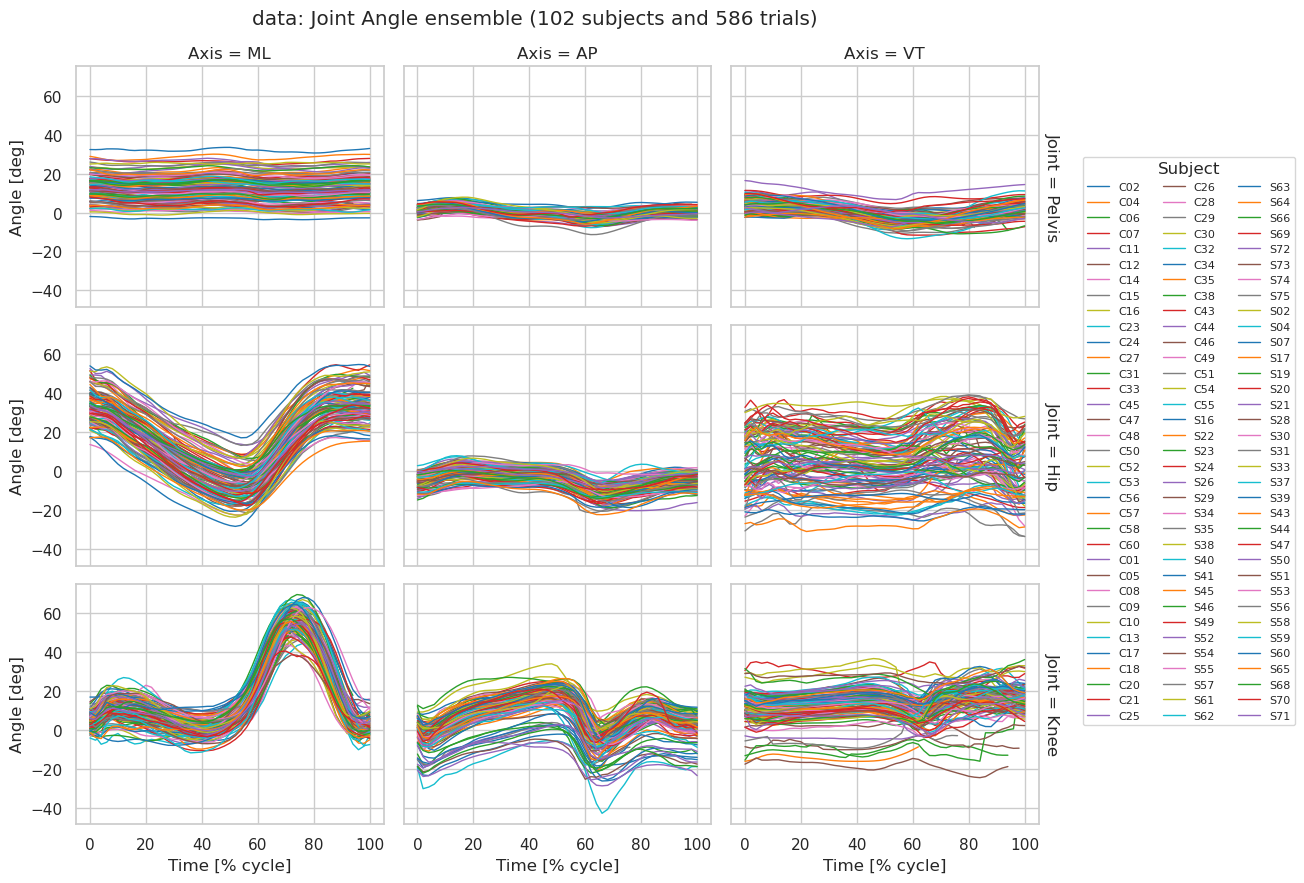

In [23]:
plot_ensemble2(path2, metadata, da, variable=variable)

In [24]:
path2 = path / 'data'
metadata = pd.read_csv(path2 /  'metadata_ERJ_T00.csv', sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
variable = 'Moment'
fname = path2 / f'{variable}_ERJ_T00.nc'
if fname.exists():
    da = xr.open_dataarray(fname.as_posix())
else:
    da = create_da2(metadata, step=2, variable=variable, path2=path2)
    da.to_netcdf(fname.as_posix())

display(da)

<xarray.DataArray 'Moment' (Time: 51, Joint: 4, Axis: 1, Trial: 10, Subject: 105)> Size: 2MB
[214200 values with dtype=float64]
Coordinates:
  * Subject  (Subject) object 840B 'C02' 'C04' 'C06' 'C07' ... 'S68' 'S70' 'S71'
  * Time     (Time) float64 408B 0.0 2.0 4.0 6.0 8.0 ... 94.0 96.0 98.0 100.0
  * Trial    (Trial) int32 40B 0 1 2 3 4 5 6 7 8 9
  * Joint    (Joint) object 32B 'Hip' 'Knee' 'Ankle' 'Support'
  * Axis     (Axis) object 8B 'ML'
Attributes:
    units:    Nm/(BM*H)

data: Joint Moment Ensemble (102 subjects and 586 trials)


/home/marcos/miniconda3/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


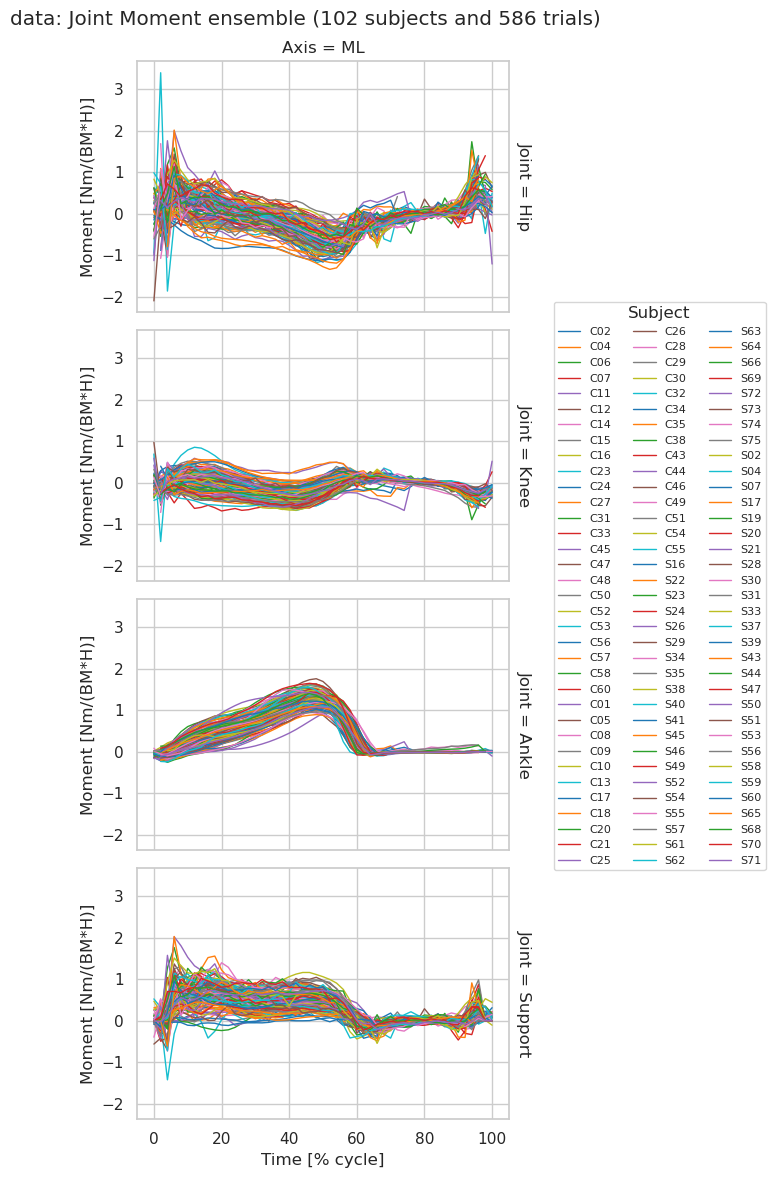

In [25]:
plot_ensemble2(path2, metadata, da, variable=variable)